In [1]:
from unityagents import UnityEnvironment
import os.path
import numpy as np
import pandas as pd
from collections import deque
import torch
from classes.dqn_agent import DQNAgent, DDQNAgent, DDQNPREAgent
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from classes.secondcounter import SecondCounter
from drawnow import drawnow, figure
%matplotlib inline
%load_ext autoreload
%autoreload 2
%matplotlib notebook
from enum import Enum
class DQN_Method(Enum):
    DQNAgent = 1
    DDQNAgent = 2
    DDQNPREAgent = 3

In [2]:
env = UnityEnvironment(
    file_name="Banana_Windows_x86_64/Banana.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]
action_size = brain.vector_action_space_size
state = env_info.vector_observations[0]
state_size = len(state)

In [5]:
def env_show_info():
    # number of agents in the environment
    print('Number of agents:', len(env_info.agents))
    # number of actions
    print('Number of actions:', action_size)
    # examine the state space
    print('States look like:', state)
    print('States have length:', state_size)    

In [6]:
def dqn_train(dqn_method: DQN_Method,
              state_size: int,
              action_size: int,
              n_episodes: int = 2000,
              max_t: int = 400,
              eps_start: float = 1.0,
              eps_end: float = 0.001,
              eps_decay: float = 0.995,
              seed: int = 0):
    """Deep Q-Learning train function.

    Params
    ======
        dqn_method (DQN_Method):    use of DQN Method
        n_episodes (int):   maximum number of training episodes
        max_t (int):        maximum number of timesteps per episode
        eps_start (float):  starting value of epsilon, for epsilon-greedy action selection
        eps_end (float):    minimum value of epsilon
        eps_decay (float):  multiplicative factor (per episode) for decreasing epsilon
    """
    df = pd.DataFrame(columns=['episode', 'score', 'min', 'max', 'std', 'mean'])
    if dqn_method == DQN_Method.DDQNAgent:
        method='ddqn'
        agent = DDQNAgent(state_size=state_size, action_size=action_size, seed=222)
    elif dqn_method == DQN_Method.DDQNPREAgent:
        method='ddqnpre'
        agent = DDQNPREAgent(state_size=state_size, action_size=action_size, seed=333)
    else:
        method='dqn'
        agent = DQNAgent(state_size=state_size, action_size=action_size, seed=111)    

    # list containing scores from each episode
    scores = []                                                                 
    # last 100 scores
    scores_window = deque(maxlen=10)                                           
    # initialize epsilon
    eps = eps_start
    
    # create the counter instance
    count = SecondCounter()
    count.start()
    for i_episode in range(1, n_episodes+1):
        # reset the environment
        env_info = env.reset(train_mode=True)[brain_name]                       
        # get the current state
        state = env_info.vector_observations[0]                                 
        # initialize score            
        score = 0                                                               
        for t in range(max_t):
            # select an action
            action = agent.act(np.array(state),eps)                             
            # cast action to int
            action = action.astype(int)
            # send the action to the environment
            env_info = env.step(action)[brain_name]                             
            # get the next state
            next_state = env_info.vector_observations[0]                        
            # get the reward
            reward = env_info.rewards[0]                                        
            # see if episode has finished
            done = env_info.local_done[0]                                       
            # send update step to agent
            agent.step(state,action,reward,next_state,done)                     
            # update the score
            score += reward                                                     
            # roll over the state to next time step
            state = next_state                                                  
            # exit loop if episode finished
            if done:                                                            
                break            
            
        # save score for 100 most recent scores
        scores_window.append(score)                                             
        # save score for episodes
        scores.append(score)         
        
        df.loc[i_episode-1] = [i_episode] + list([score, np.min(scores_window),
                                                  np.max(scores_window),
                                                  np.std(scores_window),
                                                  np.mean(scores_window)])
        
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        # print score every 10 episodes
        if i_episode % 10== 0:                                                  
            print('\rEpisode {}\tAverage Score of last 10 episodes: {:.2f}'.format(i_episode, np.mean(scores_window)), end = '')
        # save network every 100 episodes
        if i_episode % 100 == 0:                                                
             torch.save(agent.qnet.state_dict(), 'dqn_checkpoints/dqn_checkpoint_{}_{:06d}.pth'.format(method, i_episode))       
    
    seconds = count.finish()
    print('\nTraining finished with {} episodes in {:.2f} seconds'.format(n_episodes, seconds))
    torch.save(agent.qnet.state_dict(), 'dqn_checkpoints/dqn_checkpoint_{:06d}.pth'.format(n_episodes))
    return df

In [7]:
def dqn_test(agent):
    """Deep Q-Learning test function.

    Params
    ======
        agent:   DQN Agent with loaded network for testing
    """    
    # reset the environment
    env_info = env.reset(train_mode=True)[brain_name]                            
    # get the current state
    state = env_info.vector_observations[0]                                      
    # initialize score
    score = 0                                                                     
    try:
        # run until done
        while (1):                                                               
            # select an action
            action = agent.act(np.array(state), 0)                               
            # cast action to int
            action = action.astype(int)
            # send the action to the environment
            env_info = env.step(action)[brain_name]
            # get the next state
            state = env_info.vector_observations[0] 
            # get the reward
            reward = env_info.rewards[0]   
            # see if episode has finished
            done = env_info.local_done[0]
            # update the score
            score += reward                                                      
            if done:
                return score
    except Exception as e:
        print("exception:", e)
        return score

In [8]:
def dqn_analytic_of_scores(dqn_method: DQN_Method,
                           state_size: int,
                           action_size: int,
                           checkpoint_min: int = 100,
                           checkpoint_max: int = 2100,
                           checkpoint_step: int = 100,
                           n_episode_run: int = 100,
                           goal_score: float = 13.0,
                           seed: int = 0):
    """Analytic for Deep Q-Learning agent.

    Params
    ======
        dqn_method (DQN_Method):    use of DQN Method
        state_size (int):           size of state space
        action_size (int):          action numbers
        checkpoint_min (int):       start of checkpoint for analytics
        checkpoint_max (int):       end of checkpoint for analytics
        checkpoint_step (int):      steps between checkpoint        
        n_episode_run (int):        how many episodes for each checkpoints are executed
        goal_score (float):         what score has to be achieved (only used for ploting)
        seed (int):                 seed for randomizing the agent
    """    
    # initialize DQN Agent
    if dqn_method == DQN_Method.DDQNAgent:
        method='ddqn'
        agent = DDQNAgent(state_size=state_size, action_size=action_size, seed=222)
    elif dqn_method == DQN_Method.DDQNPREAgent:
        method='ddqnpre'
        agent = DDQNPREAgent(state_size=state_size, action_size=action_size, seed=333)
    else:
        method='dqn'
        agent = DQNAgent(state_size=state_size, action_size=action_size, seed=111)

    # range of checkpoints
    checkpoints = np.arange(checkpoint_min, 
                            checkpoint_max+checkpoint_step,
                            checkpoint_step)                                    
    # define X-Axis 
    X = np.arange(0, n_episode_run, 1)
    # create mesh grid for 3d plot
    X, Y = np.meshgrid(X, checkpoints)
    # create 2D-array for scores
    score_array = np.zeros(X.shape)                                             

    n_checkpoint_count = 0

    # create the counter instance
    count = SecondCounter()
    count.start()
    
    print("Starting analysing of dqn network")
    
    # iterate over checkpoints
    for n_checkpoint in checkpoints:                                            
        checkpoint_file = 'dqn_checkpoints/dqn_checkpoint_{}_{:06d}.pth'.format(method, n_checkpoint)
        # is pretrained model for checkpoint available ?
        if not os.path.isfile(checkpoint_file):                             
            print("Checkpoint file not found: {}".format(checkpoint_file))
            continue
        # load pretrained model
        agent.qnet.load_state_dict(torch.load(checkpoint_file))       
        
        # prepare scores array for all episodes
        scores = np.arange(0, n_episode_run, 1)                                 
        for n_episode in range(0, n_episode_run):
            # test agent for one episode
            score = dqn_test(agent)
            # store result in array
            scores[n_episode] = score                                           
        
        # sort array in descending order
        scores = np.sort(scores)[::-1]                                          
        # maybe it's allowed to remove the best and worst 2 elements
        for n_episode in range(0, n_episode_run):
            score_array[n_checkpoint_count][n_episode] = scores[n_episode]      # Update 2D-array 

        n_checkpoint_count += 1
        print("Checkpoint: {} - mean score over {} episodes: {}".format(
            n_checkpoint, n_episode_run, np.mean(scores)))
    
    seconds = count.finish()
    print('Analytics finished with {} episodes in {:.2f} seconds'.format(n_episode_run, seconds))

    plot_3dsurface(X, Y, score_array)

In [18]:
def plot_3dsurface(X, Y, score_array):
    """Print 3D surface plot of DQN Agent analytics

    Params
    ======
        X (np.array):           Meshgrid X Axis
        Y (np.array):           Meshgrid X Axis
        score_array (np.array)  scores of all episodes of all checkpoints
    """     
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    # Plot the surface.
    surf = ax.plot_surface(X, Y, score_array, cmap=cm.coolwarm,
                           linewidth=0, antialiased=False)

    # Customize the z axis.
    ax.set_zlim(-2, 22)
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

    # Add a color bar which maps values to colors.
    fig.colorbar(surf, shrink=0.5, aspect=5)

    plt.show()


def plot_minmax(df):
    """Print min max plot of DQN Agent analytics

    Params
    ======
        df :    Dataframe with scores
    """   
    ax  = df.plot(x='episode', y='mean')
    plt.fill_between(x='episode',y1='min',y2='max',color='lightgrey', data=df)
    x_coordinates = [0, 2100]
    y_coordinates = [13, 13]
    plt.plot(x_coordinates, y_coordinates, color='red')    
    plt.show()

In [13]:
# Test of notebook
# Train 200 episodes
train_dataframe_dqn = dqn_train(DQN_Method.DQNAgent, state_size, action_size,200)
train_dataframe_ddqn = dqn_train(DQN_Method.DDQNAgent, state_size, action_size,200)
train_dataframe_ddqnpre = dqn_train(DQN_Method.DDQNPREAgent, state_size, action_size,200)

Episode 200	Average Score of last 10 episodes: 3.70
Training finished with 200 episodes in 97.78 seconds
Episode 200	Average Score of last 10 episodes: 5.20
Training finished with 200 episodes in 107.87 seconds
Episode 200	Average Score of last 10 episodes: 6.30
Training finished with 200 episodes in 168.77 seconds


<IPython.core.display.Javascript object>


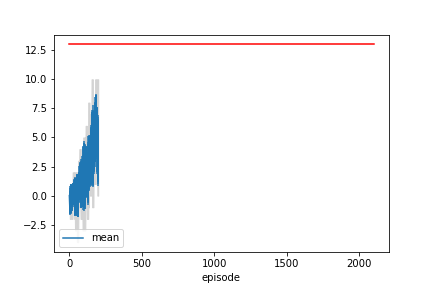

<IPython.core.display.Javascript object>


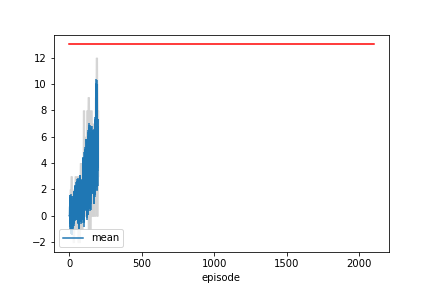

<IPython.core.display.Javascript object>


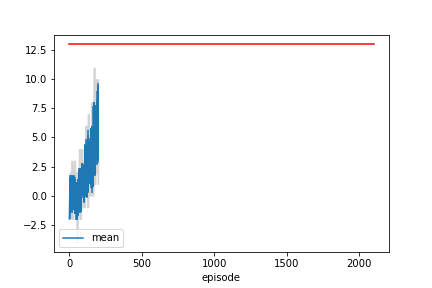

In [14]:
plot_minmax(train_dataframe_dqn)
plot_minmax(train_dataframe_ddqn)
plot_minmax(train_dataframe_ddqnpre)

Starting analysing of dqn network
Checkpoint: 100 - mean score over 10 episodes: 1.4
Checkpoint: 200 - mean score over 10 episodes: 4.4
Analytics finished with 10 episodes in 5.74 seconds


<IPython.core.display.Javascript object>


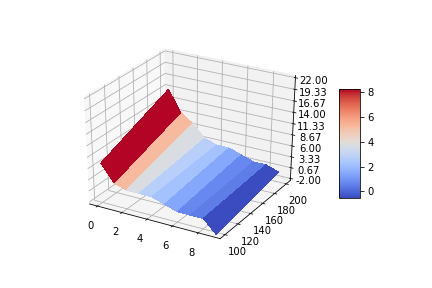

Starting analysing of dqn network
Checkpoint: 100 - mean score over 10 episodes: 4.6
Checkpoint: 200 - mean score over 10 episodes: 3.7
Analytics finished with 10 episodes in 5.61 seconds


<IPython.core.display.Javascript object>


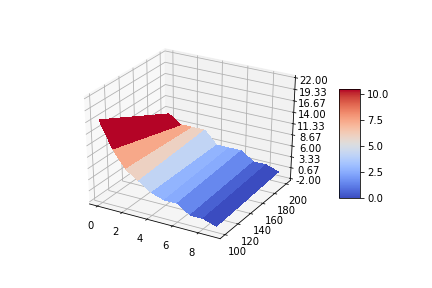

Starting analysing of dqn network
Checkpoint: 100 - mean score over 10 episodes: 1.3
Checkpoint: 200 - mean score over 10 episodes: 5.8
Analytics finished with 10 episodes in 5.62 seconds


<IPython.core.display.Javascript object>


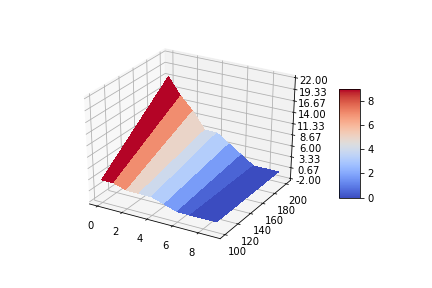

In [15]:
# Analysis until 200 Checkpoint
dqn_analytic_of_scores(DQN_Method.DQNAgent, state_size, action_size, 100, 200, 100, 10, 13, 333)
dqn_analytic_of_scores(DQN_Method.DDQNAgent, state_size, action_size, 100, 200, 100, 10, 13, 333)
dqn_analytic_of_scores(DQN_Method.DDQNPREAgent, state_size, action_size, 100, 200, 100, 10, 13, 333)

In [16]:
# Train of DQN for 2100 episodes
train_dataframe_dqn = dqn_train(DQN_Method.DQNAgent, state_size, action_size,2100)
train_dataframe_ddqn = dqn_train(DQN_Method.DDQNAgent, state_size, action_size,2100)
train_dataframe_ddqnpre = dqn_train(DQN_Method.DDQNPREAgent, state_size, action_size,2100)

Episode 2100	Average Score of last 10 episodes: 15.60
Training finished with 2100 episodes in 1048.49 seconds
Episode 2100	Average Score of last 10 episodes: 17.00
Training finished with 2100 episodes in 1140.06 seconds
Episode 2100	Average Score of last 10 episodes: 14.40
Training finished with 2100 episodes in 2045.02 seconds


<IPython.core.display.Javascript object>


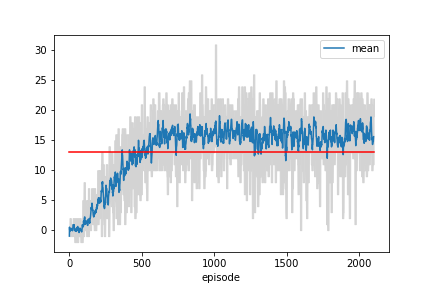

<IPython.core.display.Javascript object>


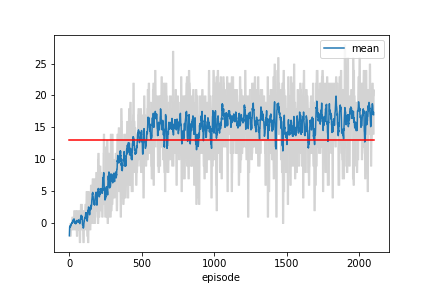

<IPython.core.display.Javascript object>


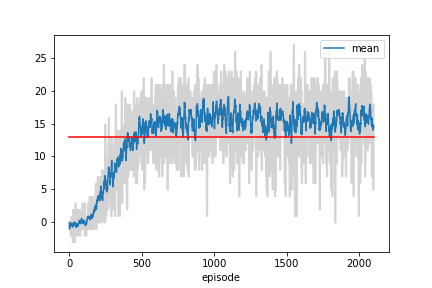

In [19]:
plot_minmax(train_dataframe_dqn)
plot_minmax(train_dataframe_ddqn)
plot_minmax(train_dataframe_ddqnpre)

Starting analysing of dqn network
Checkpoint: 100 - mean score over 10 episodes: 0.3
Checkpoint: 200 - mean score over 10 episodes: 4.7
Checkpoint: 300 - mean score over 10 episodes: 2.1
Checkpoint: 400 - mean score over 10 episodes: 5.3
Checkpoint: 500 - mean score over 10 episodes: 8.4
Checkpoint: 600 - mean score over 10 episodes: 14.1
Checkpoint: 700 - mean score over 10 episodes: 11.8
Checkpoint: 800 - mean score over 10 episodes: 14.7
Checkpoint: 900 - mean score over 10 episodes: 15.3
Checkpoint: 1000 - mean score over 10 episodes: 20.0
Checkpoint: 1100 - mean score over 10 episodes: 12.4
Checkpoint: 1200 - mean score over 10 episodes: 13.2
Checkpoint: 1300 - mean score over 10 episodes: 14.4
Checkpoint: 1400 - mean score over 10 episodes: 16.4
Checkpoint: 1500 - mean score over 10 episodes: 16.5
Checkpoint: 1600 - mean score over 10 episodes: 14.7
Checkpoint: 1700 - mean score over 10 episodes: 15.7
Checkpoint: 1800 - mean score over 10 episodes: 17.4
Checkpoint: 1900 - mean sc

<IPython.core.display.Javascript object>


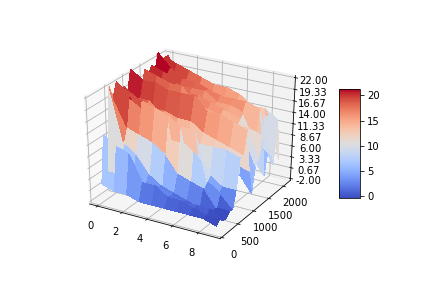

Starting analysing of dqn network
Checkpoint: 100 - mean score over 10 episodes: 1.0
Checkpoint: 200 - mean score over 10 episodes: 2.8
Checkpoint: 300 - mean score over 10 episodes: 0.6
Checkpoint: 400 - mean score over 10 episodes: 10.0
Checkpoint: 500 - mean score over 10 episodes: 14.3
Checkpoint: 600 - mean score over 10 episodes: 15.6
Checkpoint: 700 - mean score over 10 episodes: 14.7
Checkpoint: 800 - mean score over 10 episodes: 15.4
Checkpoint: 900 - mean score over 10 episodes: 11.7
Checkpoint: 1000 - mean score over 10 episodes: 16.3
Checkpoint: 1100 - mean score over 10 episodes: 17.3
Checkpoint: 1200 - mean score over 10 episodes: 15.1
Checkpoint: 1300 - mean score over 10 episodes: 17.5
Checkpoint: 1400 - mean score over 10 episodes: 19.0
Checkpoint: 1500 - mean score over 10 episodes: 14.6
Checkpoint: 1600 - mean score over 10 episodes: 14.0
Checkpoint: 1700 - mean score over 10 episodes: 17.0
Checkpoint: 1800 - mean score over 10 episodes: 14.9
Checkpoint: 1900 - mean 

<IPython.core.display.Javascript object>


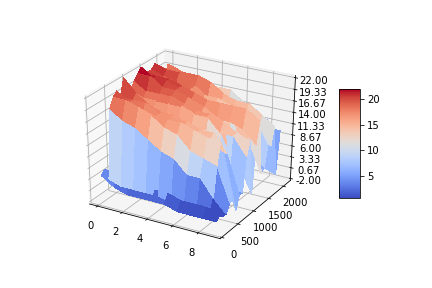

Starting analysing of dqn network
Checkpoint: 100 - mean score over 10 episodes: -0.2
Checkpoint: 200 - mean score over 10 episodes: 4.7
Checkpoint: 300 - mean score over 10 episodes: 5.0
Checkpoint: 400 - mean score over 10 episodes: 13.4
Checkpoint: 500 - mean score over 10 episodes: 8.6
Checkpoint: 600 - mean score over 10 episodes: 17.7
Checkpoint: 700 - mean score over 10 episodes: 13.3
Checkpoint: 800 - mean score over 10 episodes: 17.0
Checkpoint: 900 - mean score over 10 episodes: 15.4
Checkpoint: 1000 - mean score over 10 episodes: 13.7
Checkpoint: 1100 - mean score over 10 episodes: 18.3
Checkpoint: 1200 - mean score over 10 episodes: 16.4
Checkpoint: 1300 - mean score over 10 episodes: 16.7
Checkpoint: 1400 - mean score over 10 episodes: 15.7
Checkpoint: 1500 - mean score over 10 episodes: 15.9
Checkpoint: 1600 - mean score over 10 episodes: 15.8
Checkpoint: 1700 - mean score over 10 episodes: 17.1
Checkpoint: 1800 - mean score over 10 episodes: 15.5
Checkpoint: 1900 - mean 

<IPython.core.display.Javascript object>


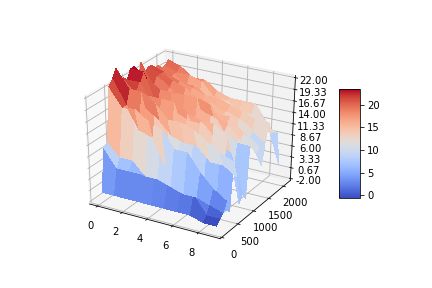

In [20]:
# Analyse until 2100 Checkpoint
dqn_analytic_of_scores(DQN_Method.DQNAgent, state_size, action_size, 100, 2100, 100, 10, 13, 333)
dqn_analytic_of_scores(DQN_Method.DDQNAgent, state_size, action_size, 100, 2100, 100, 10, 13, 333)
dqn_analytic_of_scores(DQN_Method.DDQNPREAgent, state_size, action_size, 100, 2100, 100, 10, 13, 333)